In [2]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Path to dataset (Kaggle version)
dataset_path = '/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes'

# Load all images from each class, report unreadable images
def load_and_split_by_class(dataset_path, image_size=(224, 224), train_ratio=0.8):
    X_train, y_train, X_test, y_test = [], [], [], []

    for label in sorted(os.listdir(dataset_path)):
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        files = sorted(os.listdir(class_dir))
        images = []
        failed = 0
        for file_name in files:
            file_path = os.path.join(class_dir, file_name)
            img = cv2.imread(file_path)
            if img is None:
                failed += 1
                continue
            img = cv2.resize(img, image_size)
            images.append(img)

        print(f"📂 Class '{label}': {len(images)} images loaded, {failed} failed")
        images = shuffle(images, random_state=42)
        split_idx = int(len(images) * train_ratio)
        X_train.extend(images[:split_idx])
        y_train.extend([label] * split_idx)
        X_test.extend(images[split_idx:])
        y_test.extend([label] * (len(images) - split_idx))

    return shuffle(np.array(X_train), np.array(y_train), random_state=42), shuffle(np.array(X_test), np.array(y_test), random_state=42)

(X_train, y_train), (X_test, y_test) = load_and_split_by_class(dataset_path)

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc = to_categorical(le.transform(y_test))
class_names = le.classes_.tolist()

print("✅ Each class split 80/20 successfully. Classes:", class_names)


📂 Class 'Agriculture': 800 images loaded, 0 failed
📂 Class 'Airport': 800 images loaded, 0 failed
📂 Class 'Beach': 800 images loaded, 0 failed
📂 Class 'City': 800 images loaded, 0 failed
📂 Class 'Desert': 800 images loaded, 0 failed
📂 Class 'Forest': 800 images loaded, 0 failed
📂 Class 'Grassland': 800 images loaded, 0 failed
📂 Class 'Highway': 800 images loaded, 0 failed
📂 Class 'Lake': 800 images loaded, 0 failed
📂 Class 'Mountain': 800 images loaded, 0 failed
📂 Class 'Parking': 800 images loaded, 0 failed
📂 Class 'Port': 800 images loaded, 0 failed
📂 Class 'Railway': 800 images loaded, 0 failed
📂 Class 'Residential': 800 images loaded, 0 failed
📂 Class 'River': 800 images loaded, 0 failed
✅ Each class split 80/20 successfully. Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow(X_train, y_train_enc, batch_size=32)
test_data = test_gen.flow(X_test, y_test_enc, batch_size=32, shuffle=False)


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0  
from tensorflow.keras.optimizers import Adam

# SE block definition
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

# Model definition
def build_se_efficientnet(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = se_block(x)  
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


model = build_se_efficientnet((224, 224, 3), y_train_enc.shape[1])

# Fine-tune all layers
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

 Non-trainable params: 42,023 (164.16 KB)

In [5]:
# Use callbacks to avoid overfitting and improve learning
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

history = model.fit(train_data, validation_data=test_data, epochs=30, callbacks=callbacks)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 169s 315ms/step - accuracy: 0.0932 - loss: 2.7019 - val_accuracy: 0.1158 - val_loss: 2.7051 - learning_rate: 1.0000e-05
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.2443 - loss: 2.4844 - val_accuracy: 0.1783 - val_loss: 2.6159 - learning_rate: 1.0000e-05
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.4498 - loss: 2.1601 - val_accuracy: 0.6608 - val_loss: 1.8389 - learning_rate: 1.0000e-05
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 301ms/step - accuracy: 0.6081 - loss: 1.7289 - val_accuracy: 0.7825 - val_loss: 1.2301 - learning_rate: 1.0000e-05
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 295ms/step - accuracy: 0.7031 - loss: 1.3152 - val_accuracy: 0.8479 - val_loss: 0.8322 - learning_rate: 1.0000e-05
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.7686 - loss: 0.9816 - val_accuracy: 0.8867 - val_loss: 0.5343 - learning_rate: 1.0000e-05
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 90s 293ms/step -

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
              precision    recall  f1-score   support

 Agriculture       0.96      1.00      0.98       160
     Airport       0.96      0.99      0.98       160
       Beach       0.97      1.00      0.98       160
        City       0.99      0.96      0.97       160
      Desert       0.99      0.95      0.97       160
      Forest       0.97      1.00      0.98       160
   Grassland       1.00      0.97      0.98       160
     Highway       0.96      0.99      0.98       160
        Lake       0.99      0.96      0.97       160
    Mountain       0.96      0.99      0.97       160
     Parking       0.99      0.99      0.99       160
        Port       0.98      0.97      0.98       160
     Railway       0.97      0.94      0.95       160
 Residential       0.99      0.99      0.99       160
       River       0.97      0.94      0.95       160

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0

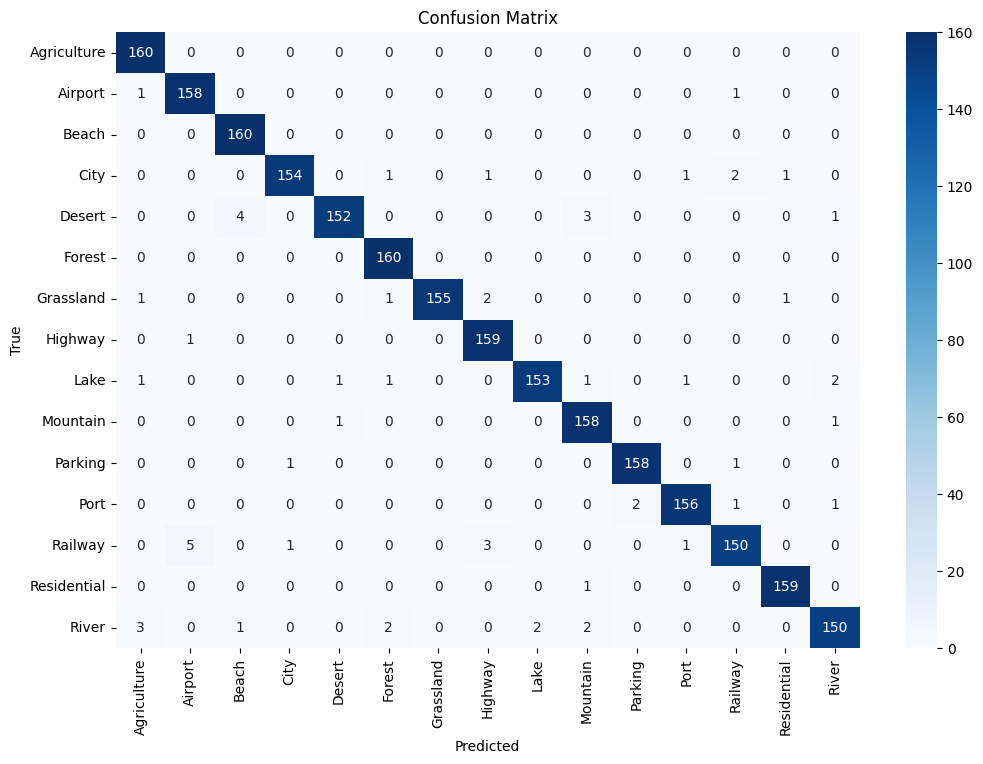

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


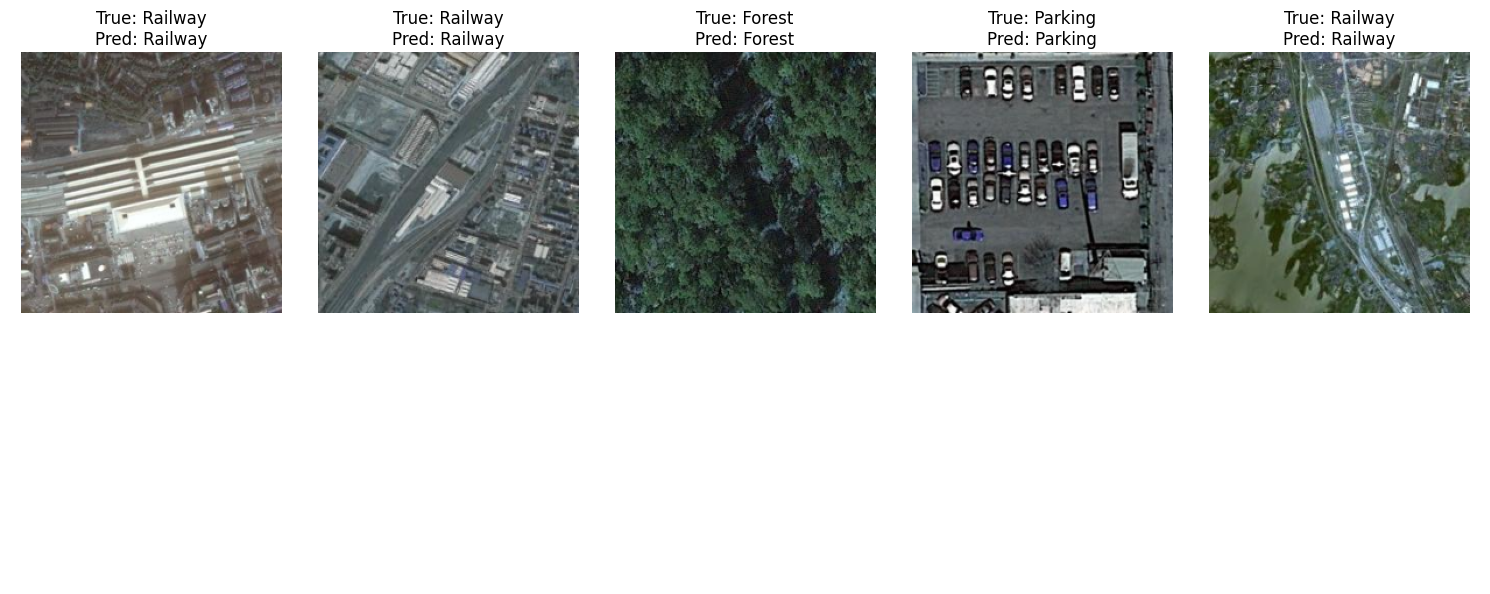

<Figure size 640x480 with 0 Axes>

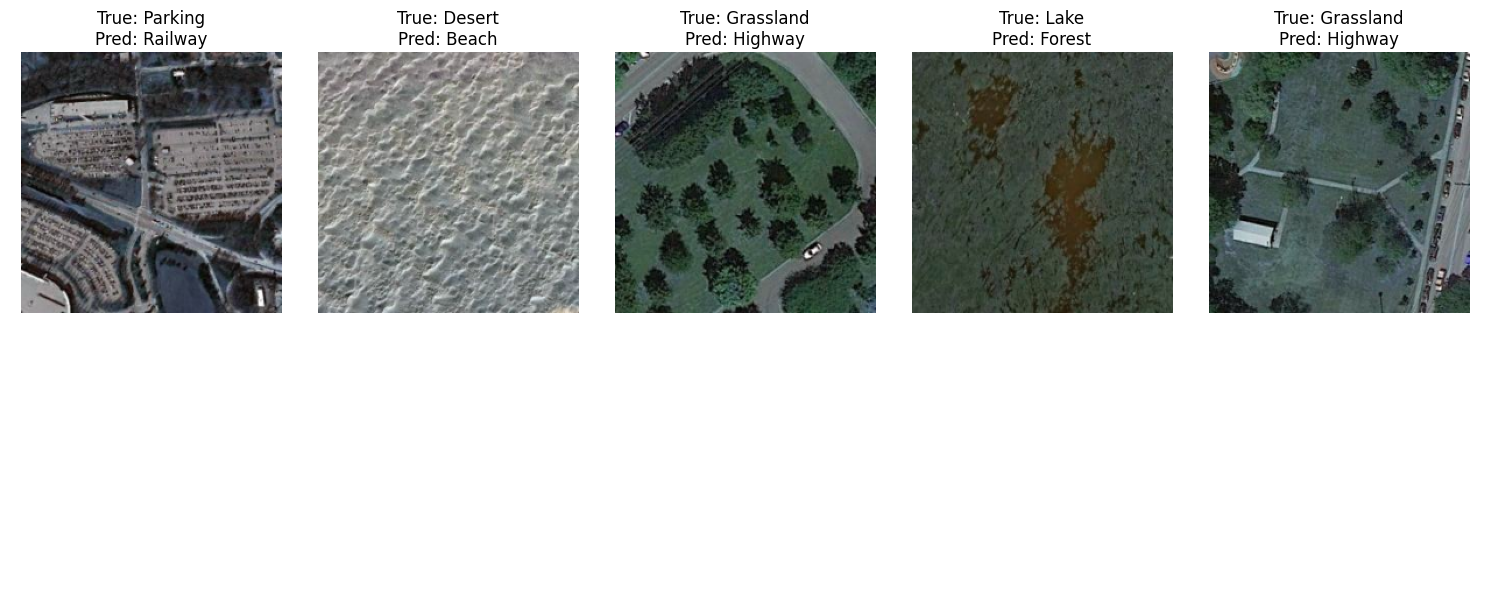

Text(0.5, 0.98, 'Incorrect Predictions')

<Figure size 640x480 with 0 Axes>

In [9]:
# Display correct and incorrect predictions
def display_predictions(images, true_labels, pred_labels, class_names, num_samples=5):
    fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Select correct and incorrect predictions
correct_indices = np.where(y_true == y_pred)[0][:5]
incorrect_indices = np.where(y_true != y_pred)[0][:5]

# Display correct predictions
display_predictions(X_test[correct_indices], y_true[correct_indices], y_pred[correct_indices], class_names, num_samples=5)
plt.suptitle("Correct Predictions")

# Display incorrect predictions
display_predictions(X_test[incorrect_indices], y_true[incorrect_indices], y_pred[incorrect_indices], class_names, num_samples=5)
plt.suptitle("Incorrect Predictions")